# import packages and some config

In [1]:
import os
import pandas as pd
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import models
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import pearsonr

torch.set_anomaly_enabled(True)


np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

In [2]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

In [3]:
os.listdir('/kaggle/input/mediaeval2016')

['mediaeval2016_annotations', 'input_test_image', 'input_train_image']

# load file

In [4]:
with open('/kaggle/input/mediaeval2016/mediaeval2016_annotations/ACCEDEranking.txt') as f:
    res = f.readlines()

res = res[1:]
path_train = '/kaggle/input/mediaeval2016/input_train_image/'

file = [path_train + r.split('\t')[1].split('.')[0] for r in res]
v_class = [float(r.split('\t')[4]) for r in res]
a_class = [float(r.split('\t')[5].rstrip()) for r in res]

In [5]:
data = pd.DataFrame(index=range(len(res)))
data['file'] = file
data['v_class'] = v_class
data['a_class'] = a_class
data

,file,v_class,a_class
0,/kaggle/input/mediaeval2016/input_train_image/...,2.764340,1.366938
1,/kaggle/input/mediaeval2016/input_train_image/...,3.260093,2.792376
2,/kaggle/input/mediaeval2016/input_train_image/...,3.047528,1.840160
3,/kaggle/input/mediaeval2016/input_train_image/...,3.338461,2.470821
4,/kaggle/input/mediaeval2016/input_train_image/...,3.042496,2.082151
...,...,...,...
9795,/kaggle/input/mediaeval2016/input_train_image/...,3.406446,1.754529
9796,/kaggle/input/mediaeval2016/input_train_image/...,3.591728,1.480602
9797,/kaggle/input/mediaeval2016/input_train_image/...,3.583121,1.450951
9798,/kaggle/input/mediaeval2016/input_train_image/...,3.564251,1.321943


In [6]:
train, valid = train_test_split(data['file'], test_size=0.1)
train_indx = train.index
valid_indx = valid.index

train_ids = data.iloc[train_indx, :]['file'].tolist()
train_labels_v = data.iloc[train_indx, :]['v_class'].tolist()
train_labels_a = data.iloc[train_indx, :]['a_class'].tolist()

valid_ids = data.iloc[valid_indx, :]['file'].tolist()
valid_labels_v = data.iloc[valid_indx, :]['v_class'].tolist()
valid_labels_a = data.iloc[valid_indx, :]['a_class'].tolist()

In [7]:
with open('/kaggle/input/mediaeval2016/mediaeval2016_annotations/MEDIAEVAL16-Global_prediction.txt') as f:
    res = f.readlines()

path_test = '/kaggle/input/mediaeval2016/input_test_image/'

test_file = [path_test + r.split('\t')[0].split('.')[0] for r in res]
test_v_class = [float(r.split('\t')[1]) for r in res]
test_a_class = [float(r.split('\t')[2].rstrip()) for r in res]

# video dataset

In [8]:
# divide 8 segment, sample one frame per segment

class VideoDataset(Dataset):
    def __init__(self, ids, labels, labels1, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
        self.labels1 = labels1

    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        dir = self.ids[idx]
        path2imgs = os.listdir(dir)
        
        path2imgs.sort(key=lambda x:int(x[5:-4]))
        path2imgs = [os.path.join(dir, i) for i in path2imgs]
        
        label = self.labels[idx]
        label1 = self.labels1[idx]

        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frames.append(frame)

        frames_tr = []
        for frame in frames:
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr) > 0:
            frames_tr = torch.stack(frames_tr)
        
        return frames_tr, label, label1

In [9]:
h, w = 224, 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [10]:
train_transform = transforms.Compose([
            transforms.RandomCrop((h, w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

val_transform = transforms.Compose([
            transforms.Resize((h, w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

In [11]:
train_ds = VideoDataset(ids=train_ids, labels=train_labels_v, labels1=train_labels_a, transform=train_transform)
print(len(train_ds))

8820


In [12]:
imgs, label, label1 = train_ds[20]
print(imgs.shape, label, label1, torch.min(imgs), torch.max(imgs))

torch.Size([8, 3, 224, 224]) 3.02849780029 2.52834782082 tensor(-2.1179) tensor(2.6400)


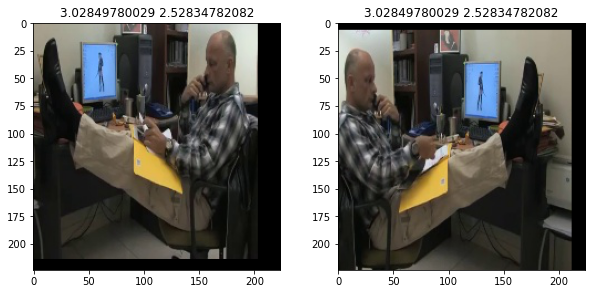

In [13]:
plt.figure(figsize=(10, 10))
for ii, img in enumerate(imgs[::4]):
    plt.subplot(2, 2, ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(str(label) + ' ' + str(label1))
plt.show()

In [14]:
val_ds = VideoDataset(ids=valid_ids, labels=valid_labels_v, labels1=valid_labels_a,transform=val_transform)
print(len(val_ds))

980


In [15]:
imgs, label, labels1 = val_ds[5]
print(imgs.shape, label, label1, torch.min(imgs), torch.max(imgs))

torch.Size([8, 3, 224, 224]) 3.13474688059 2.52834782082 tensor(-2.1179) tensor(2.6400)


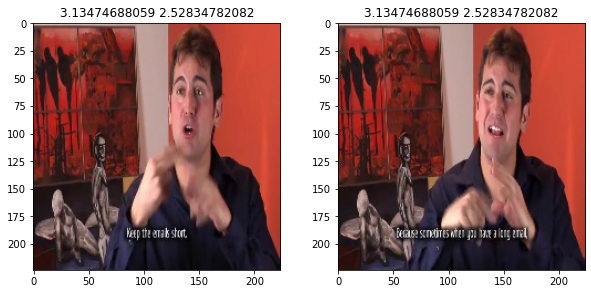

In [16]:
plt.figure(figsize=(10, 10))
for ii, img in enumerate(imgs[::4]):
    plt.subplot(2, 2, ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(str(label) + ' ' + str(label1))
plt.show()

In [17]:
test_ds = VideoDataset(ids=test_file, labels=test_v_class, labels1=test_a_class,transform=val_transform)
print(len(test_ds))

1200


In [18]:
imgs, label, labels1 = test_ds[5]
print(imgs.shape, label, label1, torch.min(imgs), torch.max(imgs))

torch.Size([8, 3, 224, 224]) 3.27071899065 2.52834782082 tensor(-2.1179) tensor(2.6400)


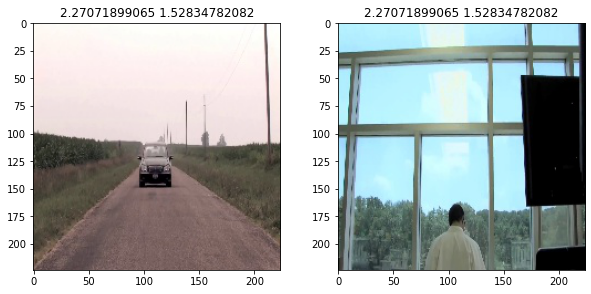

In [19]:
plt.figure(figsize=(10, 10))
for ii, img in enumerate(imgs[::4]):
    plt.subplot(2, 2, ii+1)
    plt.imshow(denormalize(img, mean, std))
    plt.title(str(label-1) + ' ' + str(label1-1))
plt.show()

# dataloader

In [20]:
def collate_fn_rnn(batch):
    imgs_batch, label_batch, label1_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    label1_batch = [torch.tensor(l) for l, imgs in zip(label1_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    labels_tensor = torch.stack(label_batch)
    labels1_tensor = torch.stack(label1_batch)
    return imgs_tensor,labels_tensor, labels1_tensor

In [21]:
batch_size = 16

train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=4, pin_memory=True,
                          shuffle=True, collate_fn=collate_fn_rnn, drop_last=True)

val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=4, pin_memory=True,
                          shuffle=True, collate_fn=collate_fn_rnn, drop_last=True)

test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=4, pin_memory=True,
                         shuffle=False, collate_fn=collate_fn_rnn, drop_last=True)

for xb, yb, yb1 in train_dl:
    print(xb.shape, yb.shape, yb1.shape)
    break
    
for xb, yb,yb1 in val_dl:
    print(xb.shape, yb.shape, yb1.shape)
    break    

for xb, yb, yb1 in test_dl:
    print(xb.shape, yb.shape, yb1.shape)
    break

torch.Size([16, 8, 3, 224, 224]) torch.Size([16]) torch.Size([16])
torch.Size([16, 8, 3, 224, 224]) torch.Size([16]) torch.Size([16])
torch.Size([16, 8, 3, 224, 224]) torch.Size([16]) torch.Size([16])


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model

In [23]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models


class ContextGating(nn.Module):
    def __init__(self, input_num):
        super(ContextGating, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.linear = nn.Linear(input_num, input_num)
    
    def forward(self, x):
        lin = self.linear(x)
        sig = self.sigmoid(lin)
        res = x * sig
        return res
    

class Visual_CNN(nn.Module):
    def __init__(self, drop_prob=0.3, pretrained=True, num_layers=3, num_classes=3):
        super(Visual_CNN, self).__init__()
        
        self.pretrained = pretrained
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.num_classes = num_classes
        
        # cnn resnet
        pretrained_cnn = models.resnet101(pretrained=self.pretrained)
        cnn_layers = list(pretrained_cnn.children())[:-1]
        self.cnn = nn.Sequential(*cnn_layers)
        
        # context gating
        self.gate = ContextGating(2048)
        
        # cnn as feature extractor
        for param in self.cnn.parameters():
            param.requires_grad = False
        
        # intermediate_fc
        self.intermediate_fc = nn.Sequential(
                nn.Linear(2048 * 2, 2048),
                ContextGating(2048))
        
        # lstm
        self.LSTM = nn.LSTM(input_size=2048, hidden_size=1024, num_layers=self.num_layers, batch_first=True)
        self.Dropout = nn.Dropout(p=self.drop_prob)
        self.w = nn.Parameter(torch.ones(8),requires_grad=True)
        
        # fc
        self.down_fc = nn.Sequential(
                nn.Linear(2048+1024, 2048),
                ContextGating(2048))
        
        self.fc_valence = nn.Sequential(
                nn.Linear(2048, 1))
        
        self.fc_arousal = nn.Sequential(
                nn.Linear(2048, 1))
        
    
    def forward(self, x_3d):
        
        cnn_embedding_out = []
        
        for t in range(x_3d.size(1)):
            x = self.cnn(x_3d[:, t, :, :, :])
            x = torch.flatten(x, start_dim=1)
            
            # context gating
            x = self.gate(x)
            cnn_embedding_out.append(x)
        
        frame_out = torch.stack(cnn_embedding_out, dim=0)
        cnn_embedding_out = torch.stack(cnn_embedding_out, dim=0).transpose(0, 1)
        
        lstm_f = cnn_embedding_out
        
        # lstm
        lstm_out, _ = self.LSTM(lstm_f)
        vecs = []
        seqlen = lstm_out.size(1)
        for s in range(seqlen):
            vec = self.Dropout(lstm_out[:, s, :]) * self.w[s]
            vecs.append(vec)
        
        lstm_out = torch.stack(vecs, dim=1)
        lstm_out = torch.mean(lstm_out, dim=1)
        
        # video-level mean and std
        x1 = torch.mean(frame_out, 0)
        tmp = frame_out.detach().cpu().numpy()
        x2 = np.std(tmp, axis=0)
        x2 = np.nan_to_num(x2)
        x2 = torch.from_numpy(x2).to(device)
        v_fea = torch.cat([x1, x2], dim=1)
        v_fea = F.normalize(v_fea, p=2, dim=1)
        v_fea = self.intermediate_fc(v_fea)
        
        # fusion
        out = torch.cat([lstm_out, v_fea], dim=1)
        out = F.normalize(out, p=2, dim=1)
        out = self.down_fc(out)
        
        # classifier
        valence = self.fc_valence(out)
        arousal = self.fc_arousal(out)
        
        return valence, arousal

In [24]:
model = Visual_CNN()
model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Visual_CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

# train

In [25]:
import os

os.makedirs('/kaggle/tmp', exist_ok=True)

In [26]:
# train

max_epoch = 20
lr = 3e-4

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0., amsgrad=True)

print('Train :')
for epoch in range(0, max_epoch):
    
    print('Epoch:', epoch)
    loss_history = []
    model.train()
    for data, target, target1 in tqdm(train_dl):

        img = data.to(device)
        target = target.to(device).float()
        target1 = target1.to(device).float()

        output = model(img)

        loss_v = criterion(output[0].squeeze(), target)

        loss_a = criterion(output[1].squeeze(), target1)

        loss = loss_v + loss_a

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        loss_history.append(float(loss))

    print('train_loss: {:.4}'.format(torch.mean(torch.Tensor(loss_history))))

    loss_history = []
    lgt = []
    lgt1 = []
    lpred = []
    lpred1 = []
    model.eval()
    for data, target, target1 in tqdm(val_dl):
        img = data.to(device)
        target = target.to(device).float().squeeze()
        target1 = target1.to(device).float().squeeze()

        output = model(img)

        loss_v = criterion(output[0].squeeze(), target)

        loss_a = criterion(output[1].squeeze(), target1)

        loss = loss_v + loss_a

        valence = output[0].squeeze()
        arousal = output[1].squeeze()

        lgt.extend(target.data.cpu().numpy())
        pt = np.float32(valence.data.cpu().numpy())
        lpred.extend(pt)

        lgt1.extend(target1.data.cpu().numpy())
        pt = np.float32(arousal.data.cpu().numpy())
        lpred1.extend(pt)

        loss_history.append(float(loss))

    gt = np.array(lgt).tolist()
    pred = np.squeeze(np.array(lpred)).tolist()
    mse_v = mean_squared_error(gt, pred)
    pcc_v = pearsonr(gt, pred)

    gt1 = np.array(lgt1).tolist()
    pred1 = np.squeeze(np.array(lpred1)).tolist()
    mse_a = mean_squared_error(gt1, pred1)
    pcc_a = pearsonr(gt1, pred1)

    print('valid_loss: {:.4}|valid_mse_v: {:.4}|valid_mse_a: {:.4}|valid_pcc_v: {:.4}|valid_pcc_a: {:.4}'.format(
        torch.mean(torch.Tensor(loss_history)),
        mse_v,
        mse_a,
        pcc_v[0],
        pcc_a[0],
    ))

    torch.save(model.state_dict(), '/kaggle/tmp/visual-cnn_r_%d.pth' % (epoch), _use_new_zipfile_serialization=False)

  0%|          | 0/551 [00:00<?, ?it/s]

Train :
Epoch: 0


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.475


100%|██████████| 61/61 [00:33<00:00,  1.85it/s]


valid_loss: 1.295|valid_mse_v: 0.4065|valid_mse_a: 0.8882|valid_pcc_v: 0.2705|valid_pcc_a: 0.3006


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.238


100%|██████████| 61/61 [00:32<00:00,  1.87it/s]


valid_loss: 1.274|valid_mse_v: 0.3825|valid_mse_a: 0.8913|valid_pcc_v: 0.3613|valid_pcc_a: 0.3281


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.229


100%|██████████| 61/61 [00:32<00:00,  1.86it/s]


valid_loss: 1.212|valid_mse_v: 0.3692|valid_mse_a: 0.8425|valid_pcc_v: 0.3537|valid_pcc_a: 0.3503


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.203


100%|██████████| 61/61 [00:33<00:00,  1.82it/s]


valid_loss: 1.274|valid_mse_v: 0.3665|valid_mse_a: 0.9074|valid_pcc_v: 0.3466|valid_pcc_a: 0.3537


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.188


100%|██████████| 61/61 [00:32<00:00,  1.90it/s]


valid_loss: 1.213|valid_mse_v: 0.366|valid_mse_a: 0.847|valid_pcc_v: 0.3615|valid_pcc_a: 0.3597


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.187


100%|██████████| 61/61 [00:32<00:00,  1.89it/s]


valid_loss: 1.252|valid_mse_v: 0.3678|valid_mse_a: 0.8844|valid_pcc_v: 0.3677|valid_pcc_a: 0.3587


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.179


100%|██████████| 61/61 [00:32<00:00,  1.86it/s]


valid_loss: 1.227|valid_mse_v: 0.3597|valid_mse_a: 0.8677|valid_pcc_v: 0.3621|valid_pcc_a: 0.3755


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.161


100%|██████████| 61/61 [00:33<00:00,  1.83it/s]


valid_loss: 1.207|valid_mse_v: 0.3783|valid_mse_a: 0.8287|valid_pcc_v: 0.3633|valid_pcc_a: 0.3775


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.156


100%|██████████| 61/61 [00:33<00:00,  1.81it/s]


valid_loss: 1.311|valid_mse_v: 0.3736|valid_mse_a: 0.9376|valid_pcc_v: 0.3464|valid_pcc_a: 0.36


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.138


100%|██████████| 61/61 [00:34<00:00,  1.77it/s]


valid_loss: 1.234|valid_mse_v: 0.3761|valid_mse_a: 0.8581|valid_pcc_v: 0.368|valid_pcc_a: 0.3811


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.143


100%|██████████| 61/61 [00:32<00:00,  1.87it/s]


valid_loss: 1.188|valid_mse_v: 0.3668|valid_mse_a: 0.8211|valid_pcc_v: 0.377|valid_pcc_a: 0.3855


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 11


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.125


100%|██████████| 61/61 [00:32<00:00,  1.85it/s]


valid_loss: 1.192|valid_mse_v: 0.3659|valid_mse_a: 0.8263|valid_pcc_v: 0.3643|valid_pcc_a: 0.3783


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 12


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.116


100%|██████████| 61/61 [00:32<00:00,  1.87it/s]


valid_loss: 1.178|valid_mse_v: 0.3605|valid_mse_a: 0.8176|valid_pcc_v: 0.389|valid_pcc_a: 0.3881


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 13


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.111


100%|██████████| 61/61 [00:33<00:00,  1.81it/s]


valid_loss: 1.196|valid_mse_v: 0.3748|valid_mse_a: 0.8208|valid_pcc_v: 0.3915|valid_pcc_a: 0.3871


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 14


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.101


100%|██████████| 61/61 [00:33<00:00,  1.84it/s]


valid_loss: 1.205|valid_mse_v: 0.377|valid_mse_a: 0.8276|valid_pcc_v: 0.3805|valid_pcc_a: 0.3739


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 15


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.092


100%|██████████| 61/61 [00:33<00:00,  1.83it/s]


valid_loss: 1.246|valid_mse_v: 0.3897|valid_mse_a: 0.8564|valid_pcc_v: 0.3847|valid_pcc_a: 0.3852


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 16


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.078


100%|██████████| 61/61 [00:32<00:00,  1.88it/s]


valid_loss: 1.203|valid_mse_v: 0.3585|valid_mse_a: 0.8441|valid_pcc_v: 0.3902|valid_pcc_a: 0.3799


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 17


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.069


100%|██████████| 61/61 [00:32<00:00,  1.86it/s]


valid_loss: 1.238|valid_mse_v: 0.3931|valid_mse_a: 0.845|valid_pcc_v: 0.3341|valid_pcc_a: 0.3723


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 18


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.07


100%|██████████| 61/61 [00:33<00:00,  1.80it/s]


valid_loss: 1.217|valid_mse_v: 0.3781|valid_mse_a: 0.8386|valid_pcc_v: 0.3514|valid_pcc_a: 0.3732


  0%|          | 0/551 [00:00<?, ?it/s]

Epoch: 19


  0%|          | 0/61 [00:00<?, ?it/s]

train_loss: 1.048


100%|██████████| 61/61 [00:33<00:00,  1.80it/s]


valid_loss: 1.287|valid_mse_v: 0.391|valid_mse_a: 0.8957|valid_pcc_v: 0.3726|valid_pcc_a: 0.3651


# test

In [27]:
# Test dataset

print('Test Accuracy:')
for epoch in range(0, max_epoch):

    print('Epoch:', epoch)
    model = Visual_CNN()
    model.to(device)

    net_weights = torch.load('/kaggle/tmp/visual-cnn_r_%d.pth' % (epoch))
    model.load_state_dict(net_weights)
    model.eval()

    lgt = []
    lgt1 = []
    lpred = []
    lpred1 = []

    for data, label, label1 in tqdm(test_dl):
        img = data.to(device)
        target = label.to(device).float()
        target1 = label1.to(device).float()

        output = model(img)

        valence = output[0].squeeze()
        arousal = output[1].squeeze()

        lgt.extend(target.data.cpu().numpy())
        pt = np.float32(valence.data.cpu().numpy())
        lpred.extend(pt)

        lgt1.extend(target1.data.cpu().numpy())
        pt = np.float32(arousal.data.cpu().numpy())
        lpred1.extend(pt)

    gt = np.array(lgt).tolist()
    pred = np.squeeze(np.array(lpred)).tolist()
    mse_v = mean_squared_error(gt, pred)
    pcc_v = pearsonr(gt, pred)

    gt1 = np.array(lgt1).tolist()
    pred1 = np.squeeze(np.array(lpred1)).tolist()
    mse_a = mean_squared_error(gt1, pred1)
    pcc_a = pearsonr(gt1, pred1)

    print('Valence Audio Test MSE:', mse_v)
    print('Arousal Audio Test MSE:', mse_a)
    print('Valence Audio Test PCC:', pcc_v[0])
    print('Arousal Audio Test PCC:', pcc_a[0])
    
    del model
    torch.cuda.empty_cache()

Test Accuracy:
Epoch: 0


100%|██████████| 75/75 [00:42<00:00,  1.76it/s]


Valence Audio Test MSE: 0.23343262536841383
Arousal Audio Test MSE: 1.1330326774793609
Valence Audio Test PCC: 0.2933231721937609
Arousal Audio Test PCC: 0.3023438482909993
Epoch: 1


100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Valence Audio Test MSE: 0.27612932679526986
Arousal Audio Test MSE: 0.9419427168112111
Valence Audio Test PCC: 0.37551079770329526
Arousal Audio Test PCC: 0.31485517154671083
Epoch: 2


100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


Valence Audio Test MSE: 0.22011992185194817
Arousal Audio Test MSE: 1.2357341927986085
Valence Audio Test PCC: 0.3638448114980106
Arousal Audio Test PCC: 0.3366354873273353
Epoch: 3


100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Valence Audio Test MSE: 0.21175814375515065
Arousal Audio Test MSE: 0.8514705290831182
Valence Audio Test PCC: 0.36156167149976043
Arousal Audio Test PCC: 0.3309184232428184
Epoch: 4


100%|██████████| 75/75 [00:41<00:00,  1.82it/s]


Valence Audio Test MSE: 0.20998420540224583
Arousal Audio Test MSE: 1.0630619098157252
Valence Audio Test PCC: 0.3779180634529845
Arousal Audio Test PCC: 0.3512506319900051
Epoch: 5


100%|██████████| 75/75 [00:40<00:00,  1.85it/s]


Valence Audio Test MSE: 0.20103803626787525
Arousal Audio Test MSE: 1.7082230819132436
Valence Audio Test PCC: 0.3851376289013563
Arousal Audio Test PCC: 0.34456507253448215
Epoch: 6


100%|██████████| 75/75 [00:42<00:00,  1.78it/s]


Valence Audio Test MSE: 0.20506780552342357
Arousal Audio Test MSE: 1.5955378473812787
Valence Audio Test PCC: 0.37814418301105623
Arousal Audio Test PCC: 0.3559735026343907
Epoch: 7


100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


Valence Audio Test MSE: 0.21896660679253638
Arousal Audio Test MSE: 1.3407333996632858
Valence Audio Test PCC: 0.36926005871505196
Arousal Audio Test PCC: 0.35577846258096835
Epoch: 8


100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


Valence Audio Test MSE: 0.21081235317008365
Arousal Audio Test MSE: 1.953610329829018
Valence Audio Test PCC: 0.367572858670121
Arousal Audio Test PCC: 0.30383502074699525
Epoch: 9


100%|██████████| 75/75 [00:40<00:00,  1.86it/s]


Valence Audio Test MSE: 0.24704699297468552
Arousal Audio Test MSE: 1.0307578357887814
Valence Audio Test PCC: 0.36747089542982314
Arousal Audio Test PCC: 0.35292891232205875
Epoch: 10


100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


Valence Audio Test MSE: 0.2082748611667362
Arousal Audio Test MSE: 1.477189720309977
Valence Audio Test PCC: 0.3877389232061484
Arousal Audio Test PCC: 0.32685795216213215
Epoch: 11


100%|██████████| 75/75 [00:41<00:00,  1.82it/s]


Valence Audio Test MSE: 0.2275747223292827
Arousal Audio Test MSE: 1.2422617578350028
Valence Audio Test PCC: 0.3710364706462719
Arousal Audio Test PCC: 0.33479315950418104
Epoch: 12


100%|██████████| 75/75 [00:41<00:00,  1.82it/s]


Valence Audio Test MSE: 0.20702962148394558
Arousal Audio Test MSE: 1.1651080472653603
Valence Audio Test PCC: 0.3805931377217795
Arousal Audio Test PCC: 0.33103789704571823
Epoch: 13


100%|██████████| 75/75 [00:41<00:00,  1.80it/s]


Valence Audio Test MSE: 0.2182603488957874
Arousal Audio Test MSE: 1.3216990773706458
Valence Audio Test PCC: 0.38588140742321014
Arousal Audio Test PCC: 0.3699509042659119
Epoch: 14


100%|██████████| 75/75 [00:41<00:00,  1.82it/s]


Valence Audio Test MSE: 0.21643437147110697
Arousal Audio Test MSE: 1.4132466505676105
Valence Audio Test PCC: 0.39275926254581606
Arousal Audio Test PCC: 0.3028256631105399
Epoch: 15


100%|██████████| 75/75 [00:42<00:00,  1.78it/s]


Valence Audio Test MSE: 0.22723975483578424
Arousal Audio Test MSE: 1.7386763980755253
Valence Audio Test PCC: 0.37649867865017544
Arousal Audio Test PCC: 0.3257898199386167
Epoch: 16


100%|██████████| 75/75 [00:41<00:00,  1.81it/s]


Valence Audio Test MSE: 0.20744626869100913
Arousal Audio Test MSE: 1.5355303054901221
Valence Audio Test PCC: 0.4048579772387653
Arousal Audio Test PCC: 0.3262770245842397
Epoch: 17


100%|██████████| 75/75 [00:40<00:00,  1.84it/s]


Valence Audio Test MSE: 0.22857111818156775
Arousal Audio Test MSE: 1.6063819013337408
Valence Audio Test PCC: 0.3496336453356396
Arousal Audio Test PCC: 0.3222238309680296
Epoch: 18


100%|██████████| 75/75 [00:42<00:00,  1.77it/s]


Valence Audio Test MSE: 0.2163830844967033
Arousal Audio Test MSE: 1.4163659402952784
Valence Audio Test PCC: 0.3729928540393756
Arousal Audio Test PCC: 0.3070910011695635
Epoch: 19


100%|██████████| 75/75 [00:42<00:00,  1.77it/s]

Valence Audio Test MSE: 0.23702187333405622
Arousal Audio Test MSE: 1.0429319236051766
Valence Audio Test PCC: 0.3592028632411379
Arousal Audio Test PCC: 0.276821367782589


In [29]:
import shutil

epoch = 13
src = '/kaggle/tmp/visual-cnn_r_%d.pth' % (epoch)
dst = 'visual-cnn_r_%d.pth' % (epoch)

shutil.move(src, dst)

'visual-cnn_r_13.pth'

In [30]:
# from IPython.display import FileLink
# FileLink(r'visual-cnn_r_13.pth')

/kaggle/working/visual-cnn_r_13.pth